In [57]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path(
).resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
import wandb
import glob
from models import reCNN_bottleneck_CyclicGauss3d, reCNN_bottleneck_CyclicGauss3d_no_scaling, Lurz_Control_Model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torchvision.transforms as transforms
import math
from Antolik_dataset import AntolikDataset, AntolikDataModule
from experiments.utils import pickle_read, download_model, get_neuron_estimates, reconstruct_orientation_maps, visualize_preferred_orientations, rotate_and_compute_distances, circular_distance
import pytorch_lightning as pl
import torch
from model_trainer import run_wandb_training
from energy_model.energy_model import EnergyModel, EnergyModelIndividual
from train_on_antolik import get_config
from model_trainer import Antolik_dataset_preparation_function, get_model

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from experiments.utils import pickle_read, download_model

In [2]:
import torch
import torch.nn as nn
def StandardizeClip(mean, std, pixel_min=None, pixel_max=None, dim=[1, 2, 3]):
    transf = [Normalize(mean=mean, std=std, dim=dim)]
    if pixel_min != None or pixel_max != None:
        transf.append(Clip(pixel_min=pixel_min, pixel_max=pixel_max))
    return nn.Sequential(*transf)
class Normalize(nn.Module):
    def __init__(self, mean=None, std=None, dim=None, eps=1e-12):
        super().__init__()
        self.mean = mean
        self.std = std
        self.dim = dim
        self.eps = eps
    def forward(self, x, iteration=None):
        x_mean = x.mean(dim=self.dim, keepdims=True)
        target_mean = self.mean if self.mean is not None else x_mean
        x_std = x.std(dim=self.dim, keepdims=True)
        target_std = self.std if self.std is not None else x_std
        return target_std * (x - x_mean) / (x_std + self.eps) #+ target_mean
#     def __repr__(self):
#         return f”Normalize(mean={self.mean}, std={self.std}, dim={self.dim})”
class Clip(nn.Module):
    def __init__(self, pixel_min, pixel_max):
        super().__init__()
        self.pixel_min = pixel_min
        self.pixel_max = pixel_max
    def forward(self, x):
        x = torch.clamp(x, min=self.pixel_min, max=self.pixel_max)
        return x
#     def __repr__(self):
#         return f”Clip(min={self.pixel_min}, max={self.pixel_max})”

In [3]:
# class TrainableImage(pl.LightningModule):
#     def __init__(self, image_size, enc, min_pixel_value=-1.757, max_pixel_value=2.0408, std=0.0000001):
#         super().__init__()
#         self.image_size = image_size
#         self.min_pixel_value = min_pixel_value
#         self.max_pixel_value = max_pixel_value
#         self.my_clip = StandardizeClip(0, std, min_pixel_value, max_pixel_value, dim=[1, 2, 3]) # dimensions!!!

#         if type(enc) == type("a"):
#             self.set_encoder(enc)
#         else:
#             self.encoder = enc
        
#         self.weights = torch.nn.Parameter(data=torch.rand((1, 1, self.image_size, self.image_size)))
#         for param in self.encoder.parameters():
#             param.requires_grad = False
    
#     def forward(self, x): # x are just ones
#         x = self.my_clip(self.weights)
#         x = self.encoder(x)
#         return x[:,0]
    
#     def get_img(self):
#         img = self.my_clip(self.weights)
#         img = img.cpu().detach().numpy()
#         return img
    
#     def show_img(self):
#         img = self.get_img()
#         plt.figure(figsize = (8,8))
#         plt.imshow(img[0, 0, :, :])

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         loss = -torch.mean(self.forward(x))
#         return loss
    
#     def plot_img(self, pixel_min, pixel_max):
#         img = self.get_img()
#         img = img[0, 0, :, :]
#         if type(img) != np.ndarray:
#             img = img.cpu().detach().squeeze().numpy()
#         plt.imshow(img, cmap="Greys_r", vmax=pixel_max, vmin=pixel_min)
#         plt.colorbar()
#         plt.show()
    
#     def clip_plot_img(self, pixel_min, pixel_max, clip_min, clip_max):
#         img = self.get_img()
#         img = img[0, 0, :, :]
#         # img[img > clip_min and img < clip_max] = 0
#         img[np.where((img > clip_min) & (img<clip_max))] = 0
#         if type(img) != np.ndarray:
#             img = img.cpu().detach().squeeze().numpy()
#         plt.imshow(img, cmap="Greys_r", vmax=pixel_max, vmin=pixel_min)
#         plt.colorbar()
#         plt.show()
    
#     def set_encoder(self, artifact_name):
#         self.encoder = download_model(artifact_name=artifact_name, model_class=Lurz_Control_Model)
    
#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.01)


In [27]:
class TrainableImage(nn.Module):
    def __init__(self, img_size, n=1, c=1):
        super().__init__()
        self.img = nn.Parameter((torch.randn(n, c,*img_size)))
    def forward(self):
        return self.img

In [74]:
def plot_img(img, pixel_min, pixel_max):
    # img = img[0, 0, :, :]
    plt.figure(figsize = (8,8))
    if type(img) != np.ndarray:
        img = img.cpu().detach().squeeze().numpy()
    plt.imshow(img, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.colorbar()
    plt.show()

In [58]:
wandb.finish()

In [62]:

encoder = download_model(artifact_name="reCNN_bottleneck_CyclicGauss3d:v954", model_class=reCNN_bottleneck_CyclicGauss3d_no_scaling)

wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
wandb: Downloading large artifact reCNN_bottleneck_CyclicGauss3d:v954, 8720.61MB. 1 files... Done. 0:0:0
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Model from ./artifacts/reCNN_bottleneck_CyclicGauss3d:v954/epoch=42-step=170133.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/auto/budejovice1/mpicek/reCNN_visual_prosthesis/readout.py:344: UserWarning: sigma is sampled from uniform distribution, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


std = 0.15


activation = 38.53889846801758: 100%|██████████| 800/800 [00:17<00:00, 46.67it/s] 


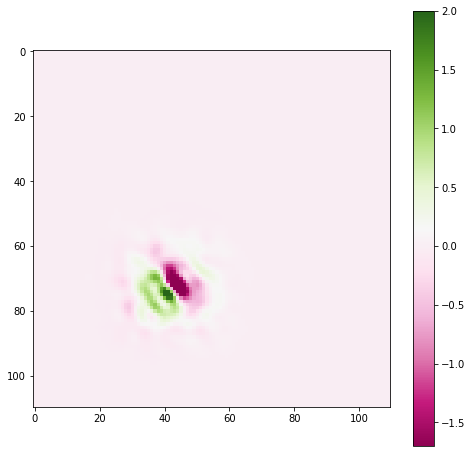

In [77]:
# encoder = download_model(artifact_name="StackedCore_FullGaussian2d:v1878", model_class=Lurz_Control_Model)
# for std in np.linspace(0.01, 0.3, 15):
    # std += 0.1
# for std in [0.001, 0.005, 0.01, 0.05]:
for std in [0.15]:
    print(f"std = {std}")

    min_pixel_value = -1.757
    max_pixel_value = 2.04
    my_clip = StandardizeClip((max_pixel_value + min_pixel_value) / 2, std, min_pixel_value, max_pixel_value)

    im = TrainableImage([110, 110])


    steps = 800
    optim = torch.optim.Adam(im.parameters(), lr=0.02)

    from tqdm import tqdm
    bar = tqdm(range(steps))

    device = "cuda" if torch.cuda.is_available() else "cpu"

    im.to(device=device)
    encoder.to(device=device)
    my_clip.to(device=device)

    im.train()
    encoder.eval()
    for step in bar:
        optim.zero_grad()
        activation = encoder(my_clip(im()))
        loss = -torch.mean(activation[:,0])
        loss.backward()
        optim.step()
        bar.set_description(f"activation = {-loss}")

        # if step % 100 == 0:
        #     with torch.no_grad():
        #         plot_img(im(), -1.7, 2)
    plot_img(my_clip(im()), -1.7, 2)
    # plot_img(im(), -1.7, 2)


In [80]:
mei = my_clip(im())

In [81]:
mei = mei.cpu().detach().numpy()

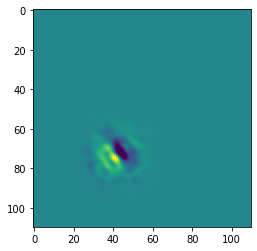

In [89]:
plt.imshow(mei[0,0,:,:])

In [214]:
def plot_img_squeezed(img, pixel_min, pixel_max):
    # img = img[0, 0, :, :]
    plt.figure(figsize = (8,8))
    if type(img) != np.ndarray:
        img = img.cpu().detach().numpy()
    plt.imshow(img, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.colorbar()
    plt.show()

In [320]:
def show_two_images(image1, image2, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()
def show_three_images(image1, image2, image3, pixel_min, pixel_max):
    # plt.figure(figsize = (8,16))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image1, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[1].imshow(image2, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    ax[2].imshow(image3, cmap="PiYG", vmax=pixel_max, vmin=pixel_min)
    plt.show()

In [314]:
class GaborFilter(nn.Module):
    def __init__(self, min_pixel_intensity=-1.7, max_pixel_intensity=2, min_sigma=0.0000000001, overall_sigma_penalty=400):
        super().__init__()
        self.sigma_x = nn.Parameter(torch.ones(1) * 6)
        self.sigma_y = nn.Parameter((torch.ones(1) * 6))
        self.f = nn.Parameter((torch.ones(1) * 1.2))
        self.ori = nn.Parameter((torch.rand(1)))
        self.pos_x = nn.Parameter((torch.rand(1)))
        self.pos_y = nn.Parameter((torch.rand(1)))
        self.shift = nn.Parameter((torch.rand(1)))
        self.scale = nn.Parameter((torch.rand(1)))
        self.overall_sigma_penalty = overall_sigma_penalty
        self.sigma_x_penalty = nn.Parameter((torch.ones(1)*(self.overall_sigma_penalty/2)))

        self.min_pixel_intensity = min_pixel_intensity
        self.max_pixel_intensity = max_pixel_intensity

        self.min_sigma = min_sigma

        x = torch.linspace(-5.5, 5.5, 110)
        y = torch.linspace(-5.5, 5.5, 110)
        self.meshgrid_x, self.meshgrid_y = torch.meshgrid(x, y)
        self.meshgrid_x = self.meshgrid_x.to('cuda')
        self.meshgrid_y = self.meshgrid_y.to('cuda')

    
    def forward(self, x):
        ori = torch.remainder(self.ori, np.pi)
        meshgrid_x_rotated = self.meshgrid_x * torch.cos(self.ori) - self.meshgrid_y * torch.sin(ori)
        meshgrid_y_rotated = self.meshgrid_x * torch.sin(self.ori) + self.meshgrid_y * torch.cos(ori)
        gaussian_filter = torch.clip(self.scale, min=self.min_pixel_intensity, max=self.max_pixel_intensity) * torch.exp(
            -0.5
            * (
                (
                    torch.square(meshgrid_x_rotated - self.pos_x)
                    / (torch.square(self.sigma_x) + self.min_sigma) # + minimum_sigma as we don't want to divide by 0
                )
                + (
                    torch.square(meshgrid_y_rotated - self.pos_y)
                    / (torch.square(self.sigma_y) + self.min_sigma) # + minimum_sigma as we don't want to divide by 0
                )
            )
        )

        cosine_filter = torch.cos(
            2
            * np.pi
            * (meshgrid_x_rotated + self.pos_x)
            * self.f
            + torch.remainder(self.shift, 2*np.pi)
        )

        gabor_filter = gaussian_filter * cosine_filter
        
        out = torch.tensordot(x, gabor_filter)
        
        img_err = torch.square(x - gabor_filter)
        return out, gabor_filter, img_err


tensor(0.0927, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4877, device='cuda:0', grad_fn=<MaxBackward1>)
0


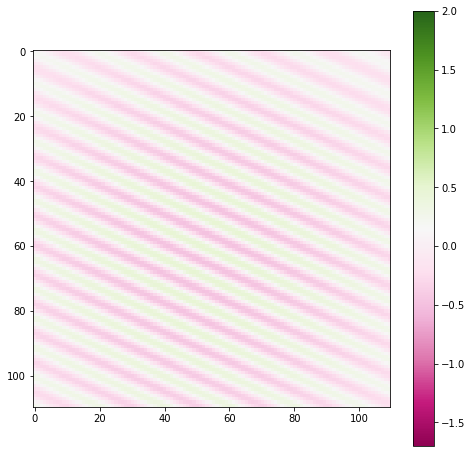

tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2554, device='cuda:0', grad_fn=<MaxBackward1>)
2000


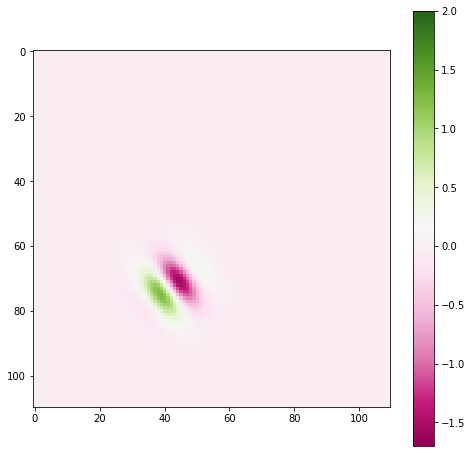

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3286, device='cuda:0', grad_fn=<MaxBackward1>)
4000


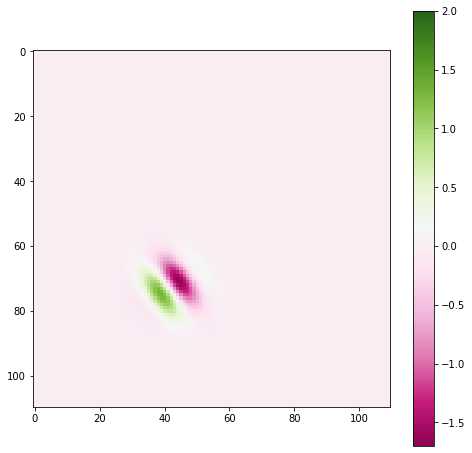

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3288, device='cuda:0', grad_fn=<MaxBackward1>)
6000


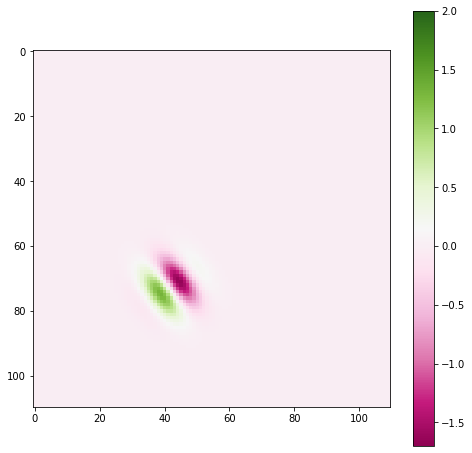

  0%|          | 0/10000 [01:27<?, ?it/s]

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3288, device='cuda:0', grad_fn=<MaxBackward1>)
8000



  0%|          | 0/10000 [00:36<?, ?it/s]


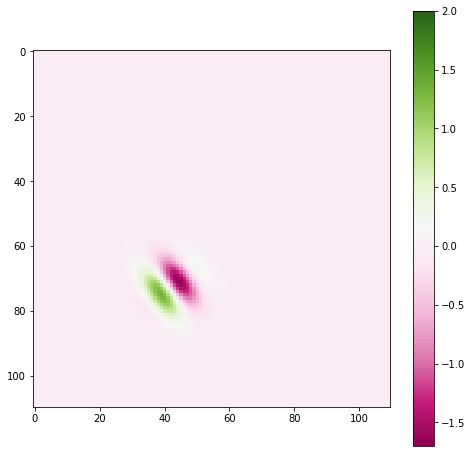

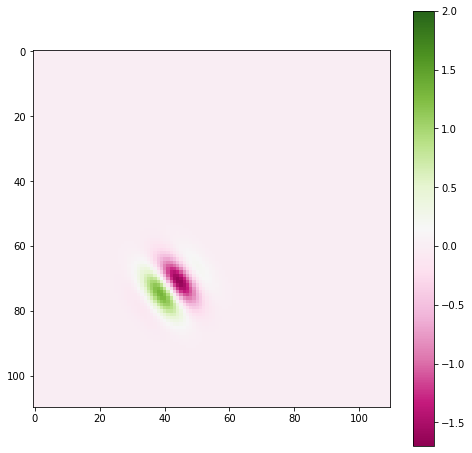

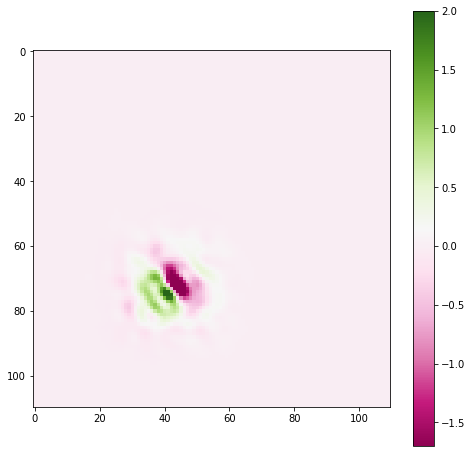

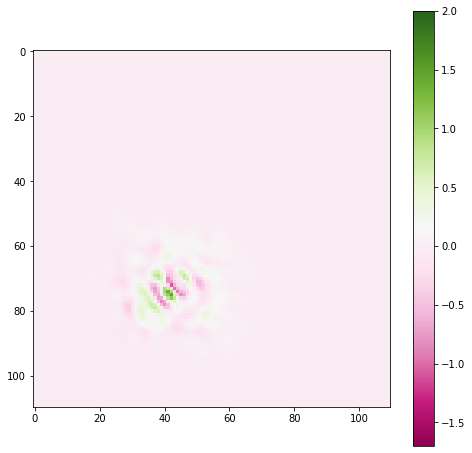

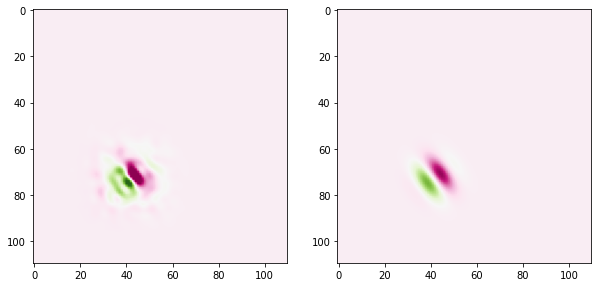

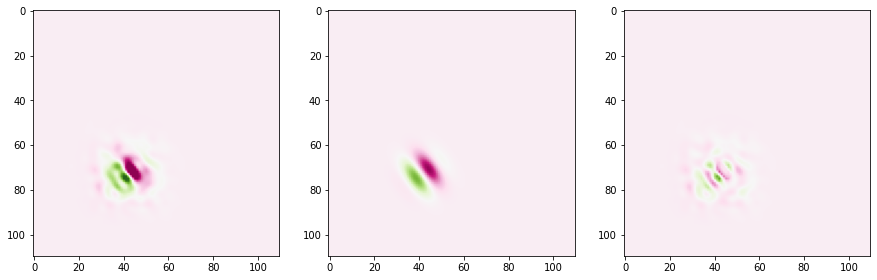

sigma_x
Parameter containing:
tensor([0.5209], device='cuda:0', requires_grad=True)
sigma_y
Parameter containing:
tensor([0.5940], device='cuda:0', requires_grad=True)
f
Parameter containing:
tensor([0.5569], device='cuda:0', requires_grad=True)
ori
Parameter containing:
tensor([0.9428], device='cuda:0', requires_grad=True)
pos_x
Parameter containing:
tensor([2.0713], device='cuda:0', requires_grad=True)
pos_y
Parameter containing:
tensor([0.7222], device='cuda:0', requires_grad=True)
shift
Parameter containing:
tensor([8.7673], device='cuda:0', requires_grad=True)
scale
Parameter containing:
tensor([2.0069], device='cuda:0', requires_grad=True)
sigma_x_penalty
Parameter containing:
tensor([200.], device='cuda:0', requires_grad=True)


In [324]:
g = GaborFilter(overall_sigma_penalty=400)
g.to(device=device)

optim = torch.optim.Adam(g.parameters(), lr=0.01)
steps_gabor = 10000
g.train()

# mei = torch.from_numpy(mei)
mei = mei.to(device=device)
# mei = mei[0,0,:,:]

gabor_bar = tqdm(range(steps_gabor))

# for step in gabor_bar:
for step in range(steps_gabor):
    optim.zero_grad()
    err, gab, img_err = g(mei)
    # if step < 6000:
    # loss = -torch.mean(err) + 200*g.sigma_x + 200*g.sigma_y
    # else:
    loss = torch.mean(img_err)
    # loss = err
    loss.backward()
    optim.step()
    # if step % 20 == 0 and step > 5500 and step < 6800:
        # print(loss)
    # gabor_bar.set_description(f"loss = {loss}")
    if step % 2000 == 0:# and step < 100:
        print(loss)
        print(gab.max())
        print(step)
        plot_img_squeezed(gab.cpu().detach().numpy(), -1.7, 2)

_, gab, _ = g(mei)
plot_img_squeezed(gab.cpu().detach().numpy(), -1.7, 2)
plot_img_squeezed(mei.cpu().detach().numpy(), -1.7, 2)
plot_img_squeezed(mei.cpu().detach().numpy() - gab.cpu().detach().numpy(), -1.7, 2)
show_two_images(mei.cpu().detach().numpy(), gab.cpu().detach().numpy(), -1.7, 2)
show_three_images(mei.cpu().detach().numpy(), gab.cpu().detach().numpy(), mei.cpu().detach().numpy() - gab.cpu().detach().numpy(), -1.7, 2)
for name, param in g.named_parameters():
    print(name)
    print(param)


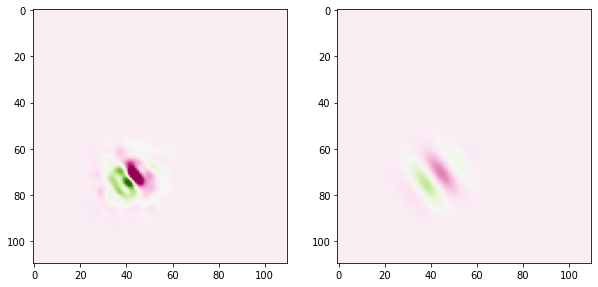

Parameter containing:
tensor([0.7971], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.7643], device='cuda:0', requires_grad=True)


In [266]:
show_two_images(mei.cpu().detach().numpy(), gab.cpu().detach().numpy(), -1.7, 2)
print(g.sigma_x)
print(g.sigma_y)

In [212]:
for name, param in g.named_parameters():
    print(name)
    print(param)

sigma_x
Parameter containing:
tensor([0.6033], device='cuda:0', requires_grad=True)
sigma_y
Parameter containing:
tensor([0.7716], device='cuda:0', requires_grad=True)
f
Parameter containing:
tensor([0.3853], device='cuda:0', requires_grad=True)
ori
Parameter containing:
tensor([0.3752], device='cuda:0', requires_grad=True)
pos_x
Parameter containing:
tensor([5.5880], device='cuda:0', requires_grad=True)
pos_y
Parameter containing:
tensor([6.5931], device='cuda:0', requires_grad=True)
bias
Parameter containing:
tensor([0.9905], device='cuda:0', requires_grad=True)


In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class OnesDataset(Dataset):
    def __init__(self, size=110, length=1000):

        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx): 
        """
            This is the critical method in this class. It allows us to get 
            an instance by an id.
        """
        ones = torch.ones(1, self.size, self.size)

        return ones, 0
    
class OneImageDataModule(pl.LightningDataModule):
    def __init__(self, size=110, batch_size=10):
        super().__init__()
        self.size = size
        self.batch_size = batch_size

    def setup(self):
        self.train = OnesDataset(self.size, 500)
        self.val = OnesDataset(self.size, 10)
        self.test = OnesDataset(self.size, 500)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)


In [5]:
dm = OneImageDataModule(size=110, batch_size=1)
dm.setup()

In [6]:
trainer = pl.Trainer(
    callbacks=[],
    max_epochs=2,
    gpus=[0],
    logger=False,
    log_every_n_steps=100,
    enable_checkpointing=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
# im(next(iter(dm)))
# im.training_step(["a", "b"], 1)
im.encoder(torch.ones(1,1,110, 110))[0][0]

tensor(7.6363)

In [26]:
im = TrainableImage(image_size=110, enc="StackedCore_FullGaussian2d:v1878", std=0.0001)
print(im.encoder(torch.ones(1,1,110, 110))[0][0])


wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


Model from ./artifacts/StackedCore_FullGaussian2d:v1878/epoch=12-step=5199.ckpt loaded!
tensor(7.2166)


In [25]:
im = TrainableImage(image_size=110, enc="StackedCore_FullGaussian2d:v1878", std=0.0001)
# im.encoder(torch.ones(1,1,110, 110))
im.encoder(torch.ones(1,1,110, 110))[0][0]
trainer.fit(
    im,
    train_dataloaders=dm.train_dataloader(),
    val_dataloaders=dm.val_dataloader(),
)
# im.training_step(["a", "b"], 1)
im.encoder(torch.ones(1,1,110, 110))[0][0]

wandb: wandb version 0.13.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Global seed set to 42
/opt/conda/lib/python3.8/site-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")
/opt/conda/lib/python3.8/site-packages/neuralpredictors/layers/cores/conv2d.py:128: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)


Model from ./artifacts/StackedCore_FullGaussian2d:v1878/epoch=12-step=5199.ckpt loaded!


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-7f7e2ca4-5018-d7a6-c449-c54a751d95e9]

  | Name    | Type               | Params
-----------------------------------------------
0 | my_clip | Sequential         | 0     
1 | encoder | Lurz_Control_Model | 1.0 M 
-----------------------------------------------
12.1 K    Trainable params
1.0 M     Non-trainable params
1.0 M     Total params
4.136     Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /auto/budejovice1/mpicek/reCNN_visual_prosthesis/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists a

Epoch 1: 100%|██████████| 500/500 [00:11<00:00, 42.52it/s, loss=-66.1]


tensor(7.6363)

In [8]:
im.weights.std()

tensor(0.1125, grad_fn=<StdBackward0>)

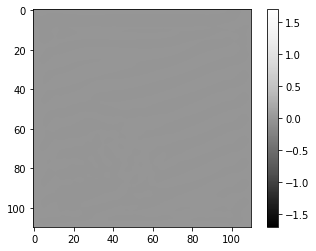

In [9]:
im.plot_img(-1.7, 1.7)

In [10]:
# im.clip_plot_img(-2, 2, -1.5, 1.5)

In [11]:
# for std in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001]:
#     print(f"std = {std}")
#     im = TrainableImage(image_size=110, enc="StackedCore_FullGaussian2d:v1878", std=std)
#     trainer.fit(
#         im,
#         train_dataloaders=dm.train_dataloader(),
#         val_dataloaders=dm.val_dataloader(),
#     )
#     im.show_img()

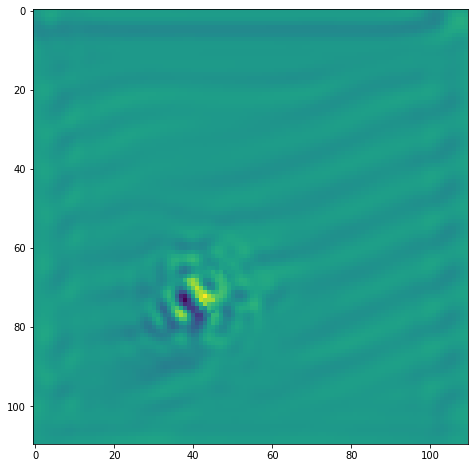

In [12]:
im.show_img()

In [13]:
im.weights.std()

tensor(0.1125, grad_fn=<StdBackward0>)

In [14]:
im.weights.std()

tensor(0.1125, grad_fn=<StdBackward0>)

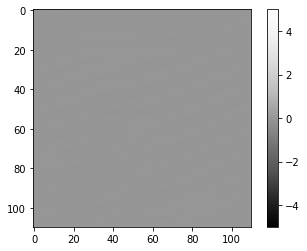

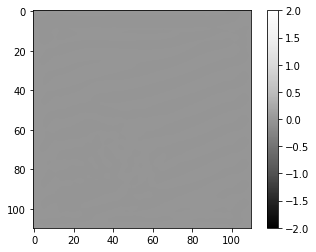

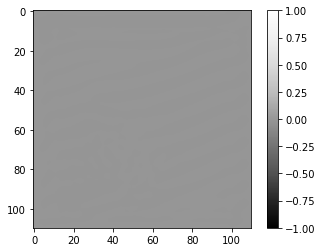

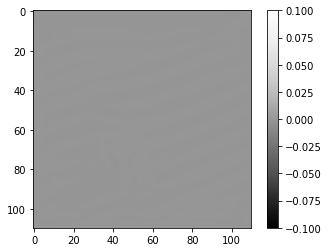

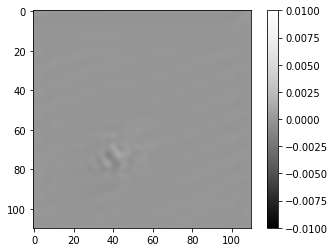

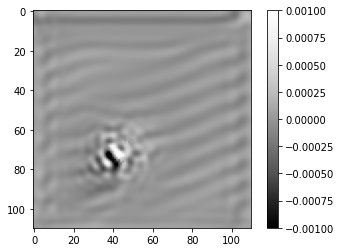

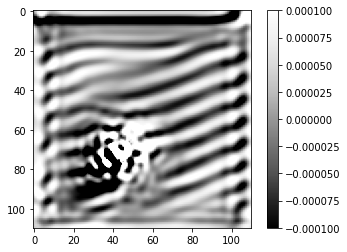

In [15]:
for i in [5, 2.0, 1.0, 0.1, 0.01, 0.001, 0.0001]:
    im.plot_img(-i, i)

In [16]:
torch.mean(im.weights)

tensor(0.4895, grad_fn=<MeanBackward0>)